In [140]:
import torch

device = torch.device(torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu')\

device

device(type='cuda')

In [141]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2
from tqdm import tqdm


class FoodDataset(torch.utils.data.Dataset):
    def __init__(self, class_list, image_folder):
        self.file_class = class_list
        self.image_folder = image_folder

    def __len__(self):
        return len(self.file_class)
    
    def __getitem__(self, idx):
        image_name = self.file_class.iloc[idx, 0]
        image_path = f"{self.image_folder}/{image_name}"
        image = Image.open(image_path).convert('RGB')

        label = self.file_class.iloc[idx, 1]
        label = torch.tensor(label, dtype=torch.long)

        preprocessing = v2.Compose([
            v2.Resize((224, 224)),
            v2.ToTensor(),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]).to(device)

        image = preprocessing(image)

        return image, label

# Dataset split

In [142]:
train_image_label = pd.read_csv('annot/train_info.csv')

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(train_image_label, train_size = 0.8, test_size=0.2, random_state=42)

c:\Users\eliau\OneDrive\Desktop\FoodClassification\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


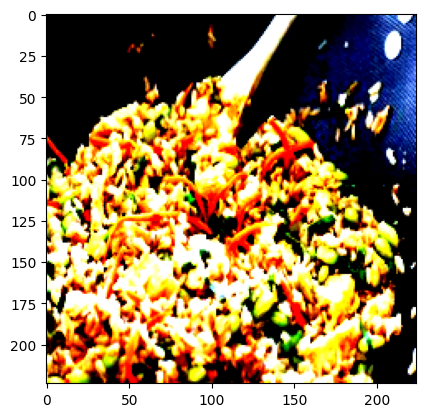

In [143]:
train_dataset = FoodDataset(train_df, 'train/train_set')
image, label = train_dataset.__getitem__(0)

plt.imshow(image.permute(1, 2, 0).numpy())

val_dataset = FoodDataset(val_df, 'train/train_set')
image_val, label_val = val_dataset.__getitem__(0)

In [144]:
test_df = pd.read_csv('annot/val_info.csv')

test_dataset = FoodDataset(test_df, 'val/val_set')
test_dataset.__getitem__(0)

c:\Users\eliau\OneDrive\Desktop\FoodClassification\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


(tensor([[[-1.6898, -2.0494, -1.9124,  ...,  1.9407,  1.9578,  2.0092],
          [-1.1932, -1.4843, -1.5357,  ...,  1.9235,  1.9407,  1.9920],
          [-0.1143, -0.6109, -0.9877,  ...,  1.9235,  1.9407,  1.9920],
          ...,
          [ 1.3413,  1.4440,  1.5125,  ...,  1.5125,  1.4612,  1.3070],
          [ 1.3755,  1.3584,  1.5125,  ...,  1.4612,  1.4612,  1.4612],
          [ 1.2557,  1.2043,  1.4440,  ...,  1.4269,  1.4440,  1.4954]],
 
         [[-1.5455, -1.9307, -1.6856,  ...,  1.9909,  2.0084,  2.0434],
          [-1.1779, -1.4405, -1.4230,  ...,  2.0084,  2.0259,  2.0609],
          [-0.2325, -0.6877, -1.0203,  ...,  2.0084,  2.0259,  2.0784],
          ...,
          [ 1.2556,  1.3782,  1.5007,  ...,  1.5882,  1.5882,  1.4482],
          [ 1.2906,  1.2731,  1.5007,  ...,  1.5357,  1.5882,  1.6057],
          [ 1.1681,  1.1331,  1.4307,  ...,  1.4832,  1.5357,  1.6057]],
 
         [[-0.7936, -1.2467, -1.0201,  ...,  2.0997,  2.1520,  2.2043],
          [-0.5670, -0.8633,

In [145]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [146]:
class FoodCNN(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(FoodCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(64 * 56 * 56, 128)
        self.fc2 = torch.nn.Linear(128, num_classes)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [147]:
cnn = FoodCNN(num_classes=251)
cnn.to(device)

sum(p.numel() for p in cnn.parameters() if p.requires_grad)

25742011

In [148]:
#train loop

num_epochs = 10
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
for epoch in range(num_epochs):
    cnn.train()
    running_loss = 0.0
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}")
cnn.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(val_dataloader):
        images, labels = images.to(device), labels.to(device)
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')
    

 13%|█▎        | 96/741 [01:47<11:59,  1.12s/it]


KeyboardInterrupt: 